In [424]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [425]:
def draw_linear(
    x: np.ndarray, 
    y_actual: np.ndarray,
    w_actual: np.ndarray,
    y_predict: np.ndarray = None,
    w_predicted: np.ndarray = None
):
  linear_grid = np.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [426]:
n_samples = 1024 * 16
n_features = 1
n_targets = 1

In [427]:
bias_actual = 32.
noise = 128

In [428]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual

y = Y.reshape((Y.shape[0], 1)) if len(Y.shape) < 2 else Y

In [429]:
X.shape, y.shape

((16384, 1), (16384, 1))

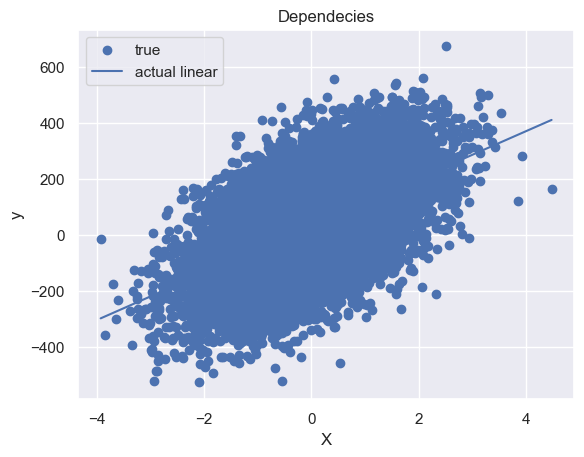

In [430]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, y, np.array([*coeff_actual, bias_actual]))

In [466]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
from common.distributor import UniformDataDistributor, DataDistributor
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [468]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [469]:
import torch

In [470]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, n_targets)
)
torch_function = TorchFunction(torch_model, torch.nn.MSELoss())

torch_enable = True

In [471]:
distributor = DataDistributor(test_size=0.4, server_fraction=0.4)
function = MSERidgeLinear(n_features=n_features)

if torch_enable:
  function = torch_function

In [472]:
from pipeline.pipeline import Pipeline

In [484]:
from common.reducers import mean, max, min

In [494]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



For parameters: {'n_clients': 64, 'iid_fraction': 0.3, 'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 512, 'rounds': 32, 'eta': 0.001}:
mse : 16172.74380789999
mae : 102.42121461371528
mape : 2.2275232484103316

For parameters: {'n_clients': 64, 'iid_fraction': 0.3, 'clients_fraction': 0.1, 'batch_size': 128, 'epochs': 512, 'rounds': 32, 'eta': 0.001}:
mse : 16764.869709930827
mae : 104.05267842188887
mape : 2.3741850811242986
done


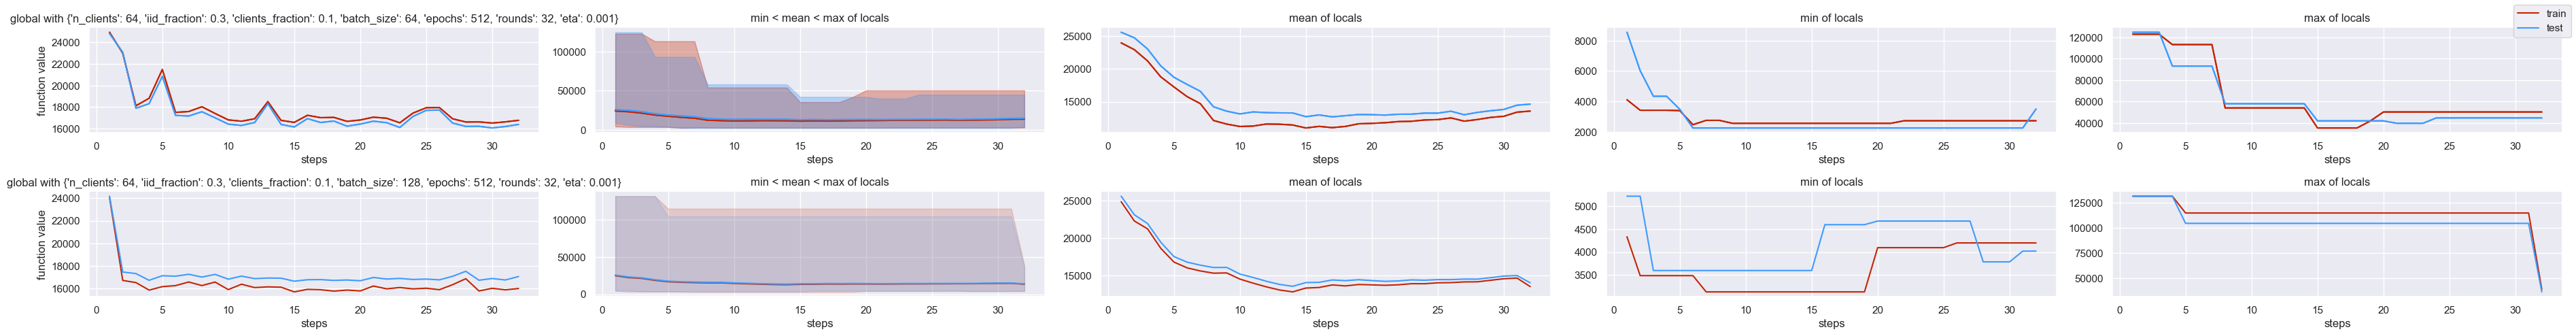

In [495]:
parameters = {
  "n_clients" : [64],
  "iid_fraction" : [0.3],
  "clients_fraction": [0.1],
  "batch_size": [64, 128], 
  "epochs": [512], # 16, 64, 
  "rounds": [32],
  "eta": [1e-3], # , 1e-2
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  function=function,
  optimizer=Scaffold,
  metrics=metrics,
  parameters=parameters,
  distributor=distributor,
  X=X,
  y=y,
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_history=True,
  scaled=False, 
  reducers=[mean(), min(), max()]
)
print("done")

In [111]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[142.0016919 ]
 [-75.02002154]]
[[127.39913808]
 [-70.78454039]]
[[102.99203914]
 [-51.46918268]]
[[112.93484916]
 [-75.03022149]]
[[ 91.54016144]
 [-41.22262259]]
[[101.11477827]
 [-92.22814237]]
[[ 70.76814066]
 [-81.67070571]]
[[ 97.69115845]
 [-55.94135101]]
[[ 97.53543694]
 [-31.76528234]]
[[ 82.13731275]
 [-40.42370448]]
[[ 90.65189836]
 [-31.4266212 ]]
[[ 81.7892518 ]
 [-26.08344735]]
[[ 68.21018323]
 [-55.05404996]]
[[ 62.15020107]
 [-63.83993616]]
[[ 74.31095289]
 [-37.49867611]]
[[ 72.15864969]
 [-48.69941825]]
[[ 76.48995736]
 [-36.32398436]]
[[ 81.54803162]
 [-16.09861949]]
[[ 69.73842697]
 [-24.26800728]]
[[ 72.60881105]
 [-22.6713205 ]]
[[ 77.30665952]
 [-18.23121831]]
[[ 59.58454636]
 [-53.7163905 ]]
[[ 64.02374074]
 [-29.54586836]]
[[ 53.52529254]
 [-38.40949464]]
[[ 54.26651857]
 [-42.91190049]]
[[ 65.12236034]
 [-35.88809011]]
[[ 65.78065382]
 [-20.82636061]]
[[64.79789989]
 [-7.19074308]]
[[ 54.84618004]
 [-41.74501908]]
[[ 55.98256315]
 [-15.3577822 ]]
[[ 54.456862

array([[41.93488277],
       [35.42677041]])

In [112]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[142.0016919 ]
 [-75.02002154]]
[[127.39913808]
 [-70.78454039]]
[[102.99203914]
 [-51.46918268]]
[[112.93484916]
 [-75.03022149]]
[[ 91.54016144]
 [-41.22262259]]
[[101.11477827]
 [-92.22814237]]
[[ 70.76814066]
 [-81.67070571]]
[[ 97.69115845]
 [-55.94135101]]
[[ 97.53543694]
 [-31.76528234]]
[[ 82.13731275]
 [-40.42370448]]
[[ 90.65189836]
 [-31.4266212 ]]
[[ 81.7892518 ]
 [-26.08344735]]
[[ 68.21018323]
 [-55.05404996]]
[[ 62.15020107]
 [-63.83993616]]
[[ 74.31095289]
 [-37.49867611]]
[[ 72.15864969]
 [-48.69941825]]
[[ 76.48995736]
 [-36.32398436]]
[[ 81.54803162]
 [-16.09861949]]
[[ 69.73842697]
 [-24.26800728]]
[[ 72.60881105]
 [-22.6713205 ]]
[[ 77.30665952]
 [-18.23121831]]
[[ 59.58454636]
 [-53.7163905 ]]
[[ 64.02374074]
 [-29.54586836]]
[[ 53.52529254]
 [-38.40949464]]
[[ 54.26651857]
 [-42.91190049]]
[[ 65.12236034]
 [-35.88809011]]
[[ 65.78065382]
 [-20.82636061]]
[[64.79789989]
 [-7.19074308]]
[[ 54.84618004]
 [-41.74501908]]
[[ 55.98256315]
 [-15.3577822 ]]
[[ 54.456862

array([[41.93488277],
       [35.42677041]])

In [113]:
best_params

{'clients_fraction': 0.3, 'batch_size': 64, 'epochs': 128, 'eta': 0.001}

  MSE: 18028.008939559943
  MAE: 107.54545703886623
  MAPE: 2.56955305725453


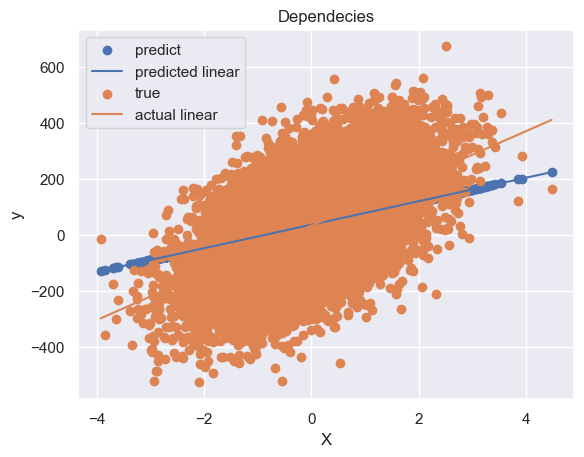

In [115]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X, y, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y, best.server.function.predict(X))}\n\
  MAE: {mean_absolute_error(y, best.server.function.predict(X))}\n\
  MAPE: {mean_absolute_percentage_error(y, best.server.function.predict(X))}\
")

In [ ]:
import torch

In [ ]:
torch.vstack((torch.Tensor([1]), torch.Tensor([1])))

tensor([[1.],
        [1.]])

In [ ]:
a = torch.arange(1, 4 * 5 + 1)
b = torch.arange(1, 4 * 1 + 1)
a, b

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
 tensor([1, 2, 3, 4]))

In [ ]:
torch.cat((a, b)).shape

torch.Size([24])

In [ ]:
a[[[1, 2, 3], [2, 2, 2]]]

tensor([ 8, 13, 18])

In [230]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

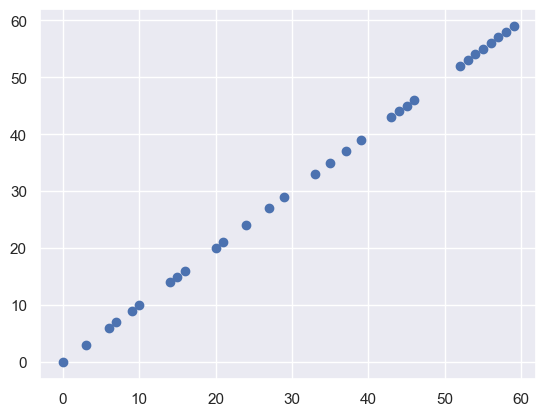

In [231]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [232]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

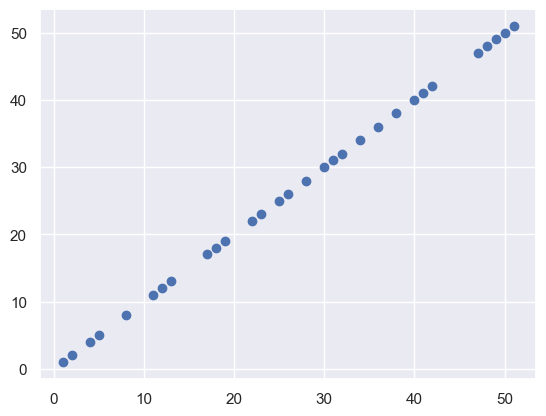

In [233]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [234]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
from common.distributor import (
  DataDistributor
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

In [323]:
y.shape

(8192, 1)

In [324]:
distrotest = DataDistributor()
data = distrotest.distribute(
  X=X,
  y=y,
  n_parts=10,
  iid_fraction=0,
  test_size=0.2
)

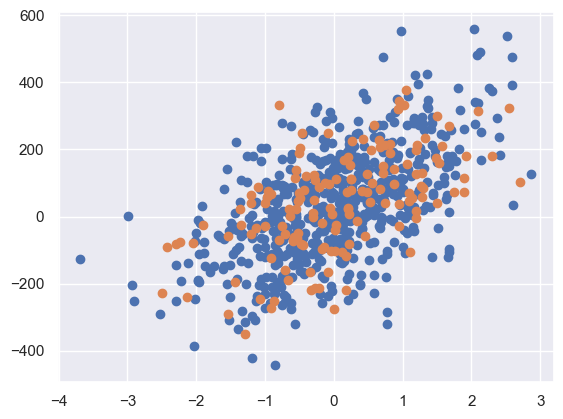

In [335]:
plt.scatter(data["train"]["X"]["server"], data["train"]["y"]["server"])
plt.scatter(data["test"]["X"]["server"], data["test"]["y"]["server"])

In [326]:
data["train"]["X"]["clients"][0].shape

(596, 1)

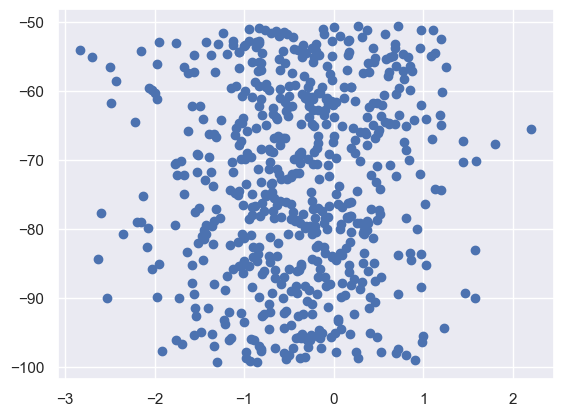

In [329]:
plt.scatter(data["train"]["X"]["clients"][2], data["train"]["y"]["clients"][2])

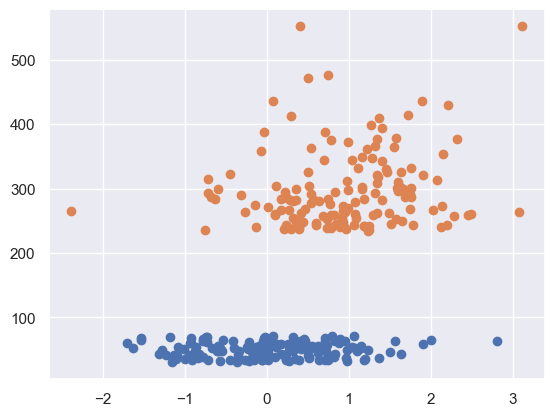

In [336]:
k = 0
for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
  if k == 5 or k == 9:
    plt.scatter(x, y)
  k += 1
# k = 0
# for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
#   if k == 1 or k == 3:
#     plt.scatter(x, y)
#   k += 1


In [ ]:
import torch
from torch import nn

In [ ]:
def check_weights(model: nn.Module):
  for i, parameters in enumerate(model.parameters()):
    print(f"\noriginal: {parameters=}\ntheory: {w[i]}\n---")

In [ ]:
def step(model: nn.Module, theory_grads, w, old_w):
  with torch.no_grad():
    for i, parameters in enumerate(model.parameters()):
      w[i] -= 1e-3 * theory_grads[i](old_w[0], old_w[1], x, y)
      parameters -= 1e-3 * parameters.grad

In [ ]:
theory_model_grad_loss_w1 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w2 * x
theory_model_grad_loss_w2 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w1 * x
theory_grads = [theory_model_grad_loss_w1, theory_model_grad_loss_w2]

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 1, bias=False), 
    nn.Linear(1, 1, bias=False), 
)
mse: nn.MSELoss = nn.MSELoss()
theory_model_loss = lambda w1, w2, x, y: (y - w1 * w2 * x) ** 2
mse

MSELoss()

In [ ]:
w = [0. for _ in range(len(model))]
x = 1
y = 1

In [ ]:
for i, parameters in enumerate(model.parameters()):
  w[i] = parameters.tolist()[0][0]
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
theory: -0.8766436576843262
---

original: parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
theory: 0.25017476081848145
---


In [ ]:
predictions = model.forward(torch.Tensor([[x]]))
y_tensor =  torch.Tensor([[y]])

loss = mse(predictions, y_tensor)
loss, theory_model_loss(w[0], w[1], x, y)

(tensor(1.4867, grad_fn=<MseLossBackward0>), 1.4867269168524473)

In [ ]:
loss.backward()

In [ ]:
for theory_grad, parameters in zip(theory_grads, model.parameters()):
  print(f"{parameters=}")
  print(f"{parameters.grad=}")
  print(f"theory_grad: {theory_grad(w[0], w[1], x, y)}\n---")

parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
parameters.grad=tensor([[-0.6101]])
theory_grad: -0.6100832353583876
---
parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
parameters.grad=tensor([[2.1378]])
theory_grad: 2.137807975459668
---


In [ ]:
from copy import copy

old_w = copy(w)

In [ ]:
step(model, theory_grads, w, old_w)

In [ ]:
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8760]], requires_grad=True)
theory: -0.8760335744489678
---

original: parameters=Parameter containing:
tensor([[0.2480]], requires_grad=True)
theory: 0.24803695284302177
---


In [ ]:
model.zero_grad()

In [ ]:
w[0] * x, w[1] * x

(-0.8760335744489678, 0.24803695284302177)

In [ ]:
import torch

from torch import nn
from typing import List


class Flattener:
  def __init__(self, parameters_generator):
    self.shapes: List[torch.Size] = []

    parameters: nn.Parameter
    for parameters in parameters_generator:
      self.shapes.append(parameters.shape)

  def flatten(self, arrays: List[torch.Tensor]) -> np.ndarray:
    flat = np.array([])
    for array in arrays:
      flat = np.append(flat, array.numpy())

    return flat

  
  def unflatten(self, flat: np.ndarray) -> List[np.array]:
    arrays: List[torch.Tensor] = []
    
    start = 0
    for shape in self.shapes:
      arrays.append(torch.Tensor(flat[start : start + shape.numel()].reshape(shape)))
      
      start += shape.numel()

    return arrays

In [ ]:
simple = nn.Sequential(
  nn.Linear(2, 1, bias=True),
  nn.Linear(1, 1, bias=True),
)
flattener = Flattener(simple.parameters())

loss = nn.MSELoss()
loss: torch.Tensor = simple.forward(torch.tensor([[1., 1.]]))
loss.backward()

updates: List[np.ndarray] = []
parameters_list: List[np.ndarray] = []

for parameters in simple.parameters():
  updates.append(parameters.grad.clone().detach())
  parameters_list.append(parameters.clone().detach())

In [ ]:
flat_updates = flattener.flatten(updates)
flat_parameters_list = flattener.flatten(parameters_list)

In [ ]:
flat_updates, flat_parameters_list

(array([-0.91267729, -0.91267729, -0.91267729, -0.07299209,  1.        ]),
 array([-0.59688079, -0.05466229,  0.57855099, -0.91267729, -0.88323534]))

In [ ]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_updates), updates)])

True

In [ ]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_parameters_list), parameters_list)])

True

In [ ]:
parameters_list

[tensor([[-0.5969, -0.0547]]),
 tensor([0.5786]),
 tensor([[-0.9127]]),
 tensor([-0.8832])]

In [ ]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [ ]:
with torch.no_grad():
  for update, parameters in zip(flattener.unflatten(flat_updates), simple.parameters()):
    parameters += update

In [ ]:
parameters_list = []
for parameters in simple.parameters():
  print(parameters)
  parameters_list.append(parameters.clone().detach().numpy())

Parameter containing:
tensor([[-1.5096, -0.9673]], requires_grad=True)
Parameter containing:
tensor([-0.3341], requires_grad=True)
Parameter containing:
tensor([[-0.9857]], requires_grad=True)
Parameter containing:
tensor([0.1168], requires_grad=True)


In [ ]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [ ]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [ ]:
parameters_list

[array([[-1.5095581, -0.9673396]], dtype=float32),
 array([-0.3341263], dtype=float32),
 array([[-0.9856694]], dtype=float32),
 array([0.11676466], dtype=float32)]

In [ ]:
array = np.arange(0, 3 * 4).reshape((3, 4))
array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
array.flatten().reshape(array.shape)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])